# CS145: Project 3 | Hacker News

## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* *Sundas Noureen (2019-CE-03)*
* *SABA (2019-CE-04)*

## Project Overview

---

Hacker News (sometimes abbreviated as HN) is a social news website focusing on computer science and entrepreneurship. It is run by the investment fund and startup incubator Y Combinator. In general, content that can be submitted is defined as "anything that gratifies one's intellectual curiosity."
The word hacker in "Hacker News" is used in its original meaning and refers to the hacker culture which consists of people who enjoy tinkering with technology.

---


## Analysis of Dataset

---
This dataset contains all stories and comments from Hacker News from its launch in 2006. Each 
story contains a story id, the author that made the post, when it was written, and the number of 
points the story received. 

There are 4 tables in this public dataset:

stories (a.k.a posts)

comments

full

full_2015

A post can have many comments.

A comment can have many comments.

Posts can have scores.

Posts have rankings showing their popularity.

So the structure is:

Story

comment

   comment

comment

## Data Exploration

In [1]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "project3-db-346816"

In [2]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [3]:
# Add imports for any visualization libraries you may need
import matplotlib.pyplot as plt

%matplotlib inline

---
 ## 1) Prolific commenters 
---

Hacker News would like to send awards to everyone who has written more than 10,000 posts. Write a query that returns all authors with more than 10,000 posts as well as their post counts.


In [ ]:
%%bigquery --project $project_id prolific_commenters
SELECT
  author,
  COUNT(1) AS NumPosts
FROM
  `bigquery-public-data.hacker_news.comments`
WHERE 
  author IS NOT NULL
GROUP BY
  author
HAVING
  COUNT(1) > 10000
LIMIT
  50

Text(0, 0.5, 'Num_Of_Posts')

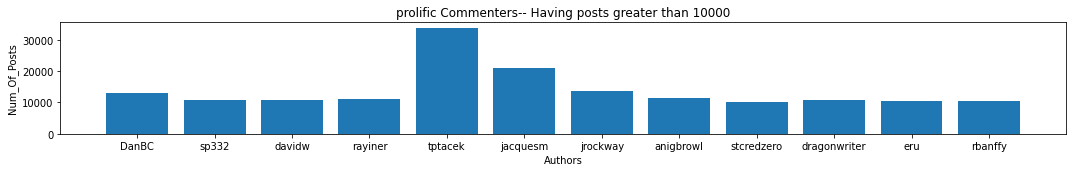

In [ ]:
# YOUR PLOT CODE HERE
plt.figure()
plt.rcParams["figure.figsize"] = [15, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.bar(prolific_commenters["author"], prolific_commenters["NumPosts"])
plt.title("prolific Commenters-- Having posts greater than 10000")
plt.xlabel("Authors")
plt.ylabel("Num_Of_Posts")

---
 ## 2) Most Commented Posts 
---

Write a query which shows posts that has highest number of comments. 


In [ ]:
%%bigquery --project $project_id mcp
SELECT
  parent,
  COUNT(*) AS number_of_comments
FROM
  `bigquery-public-data.hacker_news.comments`
GROUP BY
  parent
HAVING
  COUNT(*) > 500
ORDER BY
  number_of_comments DESC
LIMIT
  50

Text(0, 0.5, 'Num_Of_Comments')

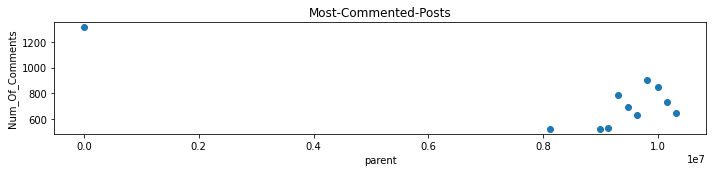

In [ ]:
# YOUR PLOT CODE HERE
plt.figure()
plt.rcParams["figure.figsize"] = [15, 2.50]
plt.rcParams["figure.autolayout"] = True
plt.scatter(mcp["parent"], mcp["number_of_comments"])
plt.title("Most-Commented-Posts")
plt.xlabel("parent")
plt.ylabel("Num_Of_Comments")

## 3) Highly Scored Stories

In [ ]:
%%bigquery --project $project_id hs
SELECT 
   score, title    
FROM 
  `bigquery-public-data.hacker_news.stories`
WHERE 
   score>250
ORDER BY 
   score DESC
LIMIT 
   10

Text(0, 0.5, 'score')

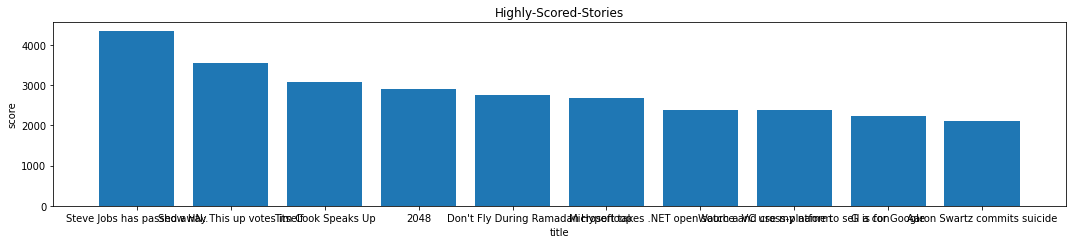

In [ ]:
# YOUR PLOT CODE HERE
plt.figure()
plt.bar(hs["title"], hs["score"])
plt.title("Highly-Scored-Stories")
plt.xlabel("title")
plt.ylabel("score")

## 4) Stories Not Dead or Deleted

In [ ]:
%%bigquery --project $project_id snd
SELECT
   COUNT(id) AS not_dead_deleted_stories
FROM
  `bigquery-public-data.hacker_news.stories`
WHERE
  deleted IS NOT TRUE
  AND dead IS NOT TRUE

## 5) Hacker News has received complaints that the site is biased towards Y Combinator startups. Do the data support this?

In [ ]:
%%bigquery --project $project_id p
WITH
  startup_ranking_score AS (
  SELECT
    CASE
      WHEN title LIKE "%Airbnb%" OR text LIKE "%Airbnb%" THEN "Airbnb"
      WHEN title LIKE "%Stripe%"
    OR text LIKE "%Stripe%" THEN "Stripe"
      WHEN title LIKE "%Dropbox%" OR text LIKE "%Dropbox%" THEN "Dropbox"
      WHEN title LIKE "%Zapier%"
    OR text LIKE "%Zapier%" THEN "Zapier"
      WHEN title LIKE "%Reddit%" OR text LIKE "%Reddit%" THEN "Reddit"
  END
    AS popular_startup_name,
    ranking,
    score
  FROM
    `bigquery-public-data.hacker_news.full` 
  )
SELECT
  popular_startup_name,
  SUM(ranking) AS total_ranking,
  SUM(score) AS total_score
FROM
  startup_ranking_score
WHERE popular_startup_name IS NOT NULL
GROUP BY
  popular_startup_name
ORDER BY
  total_score DESC

Text(0, 0.5, 'total_score')

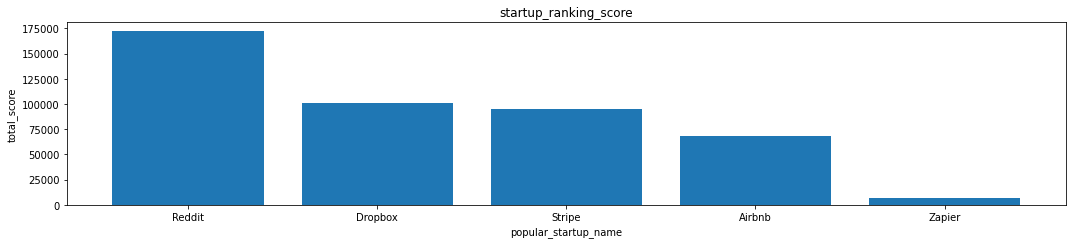

In [ ]:
# YOUR PLOT CODE HERE
plt.figure()
plt.bar(p["popular_startup_name"], p["total_score"])
plt.title("startup_ranking_score")
plt.xlabel("popular_startup_name")
plt.ylabel("total_score")

## Data Prediction

---
Create a dataset to store the model
---




In [5]:
# Run this cell to create a dataset to store your model, or create in the UI

model_dataset_name = 'hacker_news'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

Dataset(DatasetReference('project3-db-346816', 'hacker_news'))

---
Train a model
---

---
Predicting score from titles
---

In [37]:
%%bigquery --project $project_id

# YOUR QUERY HERE

CREATE OR REPLACE MODEL
  `hacker_news.HN_model` OPTIONS(model_type='linear_reg') AS
SELECT
  score AS label,
  title AS feature
FROM
  `bigquery-public-data.hacker_news.stories`
WHERE
  score <250
  AND title LIKE "%security"

""


---
Statistics Of Model
---


In [38]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `hacker_news.HN_model`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,19,7.845067e-08,None,104857.6,2621
1,0,18,1.568982e-07,None,52428.8,2810
2,0,17,3.137924e-07,None,26214.4,2882
3,0,16,6.275879e-07,None,13107.2,2706
4,0,15,1.255229e-06,None,6553.6,2443
5,0,14,2.510759e-06,None,3276.8,2549
6,0,13,5.022908e-06,None,1638.4,2490
7,0,12,1.005180e-05,None,819.2,2775
8,0,11,2.012857e-05,None,409.6,2652
9,0,10,4.035999e-05,None,204.8,2477


---
Evaluate Model
---

In [64]:
%%bigquery --project $project_id

# YOUR QUERY HERE
SELECT
  *
FROM
  ML.EVALUATE(MODEL `hacker_news.HN_model`, (
SELECT
  score as label,
  title as feature
FROM
  `bigquery-public-data.hacker_news.stories`
WHERE
  score < 250
  AND title LIKE "%security"
))

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,5.043247,245.636034,0.505011,2.150915,0.562085,0.567964


---
Evaluate final model on test set
---

In [63]:
%%bigquery --project $project_id

# YOUR QUERY HERE
SELECT
  *
FROM
  ML.EVALUATE(MODEL `hacker_news.HN_model`, (
SELECT
  score as label,
  title as feature
FROM
  `bigquery-public-data.hacker_news.stories`
WHERE
  score < 1000
  AND title LIKE "%security"
))

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,8.723427,1860.65805,0.687637,2.150915,0.125758,0.14011


---
Use the trained model to predict
---

In [62]:
%%bigquery --project $project_id

# YOUR QUERY HERE
SELECT
*
FROM
 ML.PREDICT(MODEL `hacker_news.HN_model`, (
SELECT
 score,
 title as feature
FROM
 `bigquery-public-data.hacker_news.stories`
where score between 3 and 5
  AND title LIKE "%security"))

LIMIT 20

,predicted_label,score,feature
0,3.215563,3,Ask HN: Need your input on an idea in the real...
1,4.710915,4,Tell HN: Unfuddle (svn hosting) has bad passwo...
2,3.215563,5,Download HD Instagram image bypassing instagra...
3,3.215563,3,A Civil Perspective on Cybersecurity
4,4.190915,3,Introduction to API(REST) security
5,4.190915,3,Research on poker a good deal for airport secu...
6,4.190915,3,Hacker news for security
7,4.190915,3,8-Year-Old CEO Reuben Paul Proves That Kids Ar...
8,3.670915,3,Beginner’s Guide to API(REST) security
9,4.190915,3,Test/grade your email server security


## Conclusion

---

We can predict a score of the story from title. In the above model, we have predicted the score of those stories whose title contain word security. Now we can easily predict scores of security related stories. 

---